# Bayesian modelling of developmental neurotoxicity

## Conceptual framework

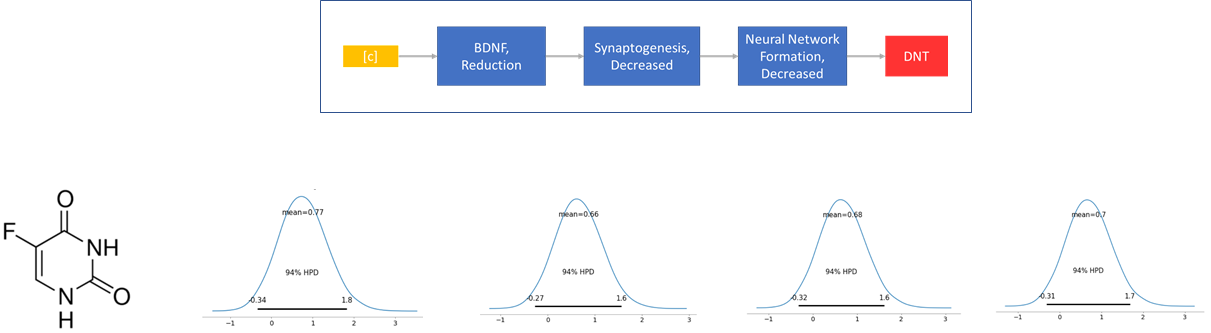

## Background

Developmental neurotoxicity does not have approved *in vitro* models or alternative models to animal testing in order to screen chemicals for their potential adverse effects.

Developmental neurotoxicity refers to impairment of cognitive function including learning and memory, Alzheimer disease.

There is a need for computational models to overcome the issue in designing appropriate wet experiments and facilitate the chemical risk assessment.



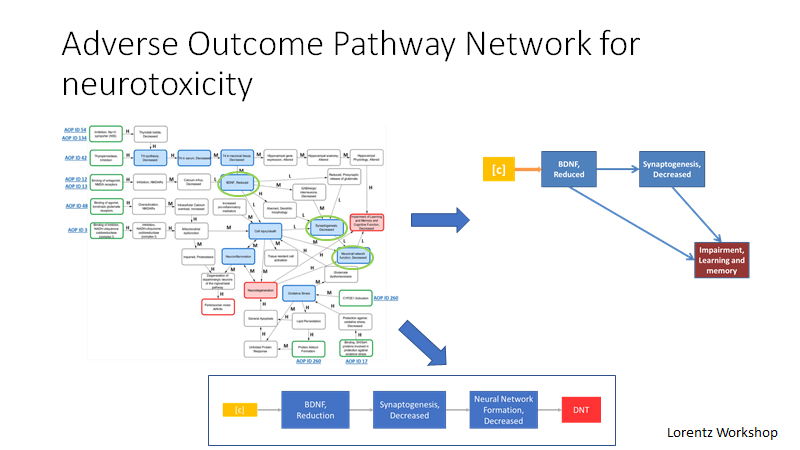

## Aim

Following the previous work conducted to develop a network of linear paths that a chemical can induce at molecular, cellular, tissue and organ levels, the aim herein, is to quantify the key events for which available data exist. Specifically,
*   To quantify three key events: reduction of BDNF, decrease in synaptogenesis and neural network function;
*   To predict the probability a chemical that can induce a key event and overall, the developmental neurotoxicity in a binary system (yes or no);
*   To demonstrate the utility of Bayesian approach to integrate a variety types of data: *in silico*, *in vitro*, physico-chemical properties including unbalanced and missing information.





## Dataset

Frank et al 2017 and Harill et al 2018 datasets were merged and additional details were collected from public available resources.

Importantly, the missing values for Synaptogenesis and NNF are not at random. If a chemical didn't show activity, the EC30 or EC50 and the viability (ATP or LDH) cannot be calculated.

| Feature       | Description | Type | Source | 
| ----------- | :--------------------------------------------: | :------------: | :----: |
| DNT Classification |  Yes or No based on *in vivo* studies  |       Binary        | [Mundy et al 2015](https://doi.org/10.1016/j.ntt.2015.10.001)|
| Chemical Name |   Chemical identification   |       NA       |  [Harill et al 2018;](https://doi.org/10.1016/j.taap.2018.04.001) [Frank et al 2017](https://doi.org/10.1093/toxsci/kfx169)|
| CASRN  |  Chemical identification  |   NA    | [Harill et al 2018;](https://doi.org/10.1016/j.taap.2018.04.001) [Frank et al 2017](https://doi.org/10.1093/toxsci/kfx169)|
| SLogP |  Physico-chemical property |       Continuous        | [KNIME RDKit](https://www.knime.com/rdkit) |
| BBB       |   Yes or No based on permeability   |       Binary      |       Literature, [Online Predictor](https://www.cbligand.org/BBB/), [admetSAR](http://lmmd.ecust.edu.cn/admetsar2/)|
| Cbrain/Cblood  |  *In vivo* BBB penetration  |  Continuous | [PreADMET](https://preadmet.bmdrc.kr/adme-prediction/)|
| Pgp Inhibition |  Yes or No  |  Binary   | [Mora Lagares et al 2019](https://doi.org/10.3390/molecules24102006) |
| Pgp Substrate |  Yes or No  |  Binary  | [Mora Lagares et al 2019](https://doi.org/10.3390/molecules24102006) |
| Pgp Activity |  Yes or No  | Binary  | [Mora Lagares et al 2019](https://doi.org/10.3390/molecules24102006) |
| BDNF, Reduction| Yes or No | Binary |  Literature review  |
| Activity Synaptogenesis| Selectivity and potency of a chemical | Categorical |  [Harill et al 2018](https://doi.org/10.1016/j.taap.2018.04.001)  |
| Viability Synaptogenesis| ATP level | Continuous |  [Harill et al 2018](https://doi.org/10.1016/j.taap.2018.04.001)  |
| EC30 Synaptogenesis| 30% change comparing to control | Continuous |  [Harill et al 2018](https://doi.org/10.1016/j.taap.2018.04.001)  |
| Activity NNF| Selectivity and potency of a chemical | Categorical |  [Frank et al 2017](https://doi.org/10.1093/toxsci/kfx169)  |
| Viability NNF| LDH level | Continuous |  [Frank et al 2017](https://doi.org/10.1093/toxsci/kfx169)  |
| EC50min NNF| 50% change comparing to control | Continuous |  [Frank et al 2017](https://doi.org/10.1093/toxsci/kfx169)  |
| EC50max NNF| 50% change comparing to control | Continuous |  [Frank et al 2017](https://doi.org/10.1093/toxsci/kfx169)  |






## Initial setup

In [ ]:
#Google Colab requires specific versions of the following packages in order to run Arviz
!pip install arviz==0.6.1
!pip install pymc3==3.8
!pip install Theano==1.0.4
print("Packages installed successfully!")

     |████████████████████████████████| 1.4MB 1.7MB/s 
     |████████████████████████████████| 4.1MB 10.5MB/s 
     |████████████████████████████████| 286kB 25.9MB/s 
     |████████████████████████████████| 911kB 1.7MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7
Packages installed successfully!


In [ ]:
#Import libraries
import pandas as pd
from pandas import DataFrame
import numpy as np
from patsy import dmatrices, dmatrix

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from scipy import stats

import theano
import pymc3 as pm
import arviz as az
import theano.tensor as tt

print("Packages uploaded successfully!")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Packages uploaded successfully!


In [ ]:
#Check the versions
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.8


## Data preprocessing

In [ ]:
#Upload data as csv file from the local computer
from google.colab import files
uploaded = files.upload()

Saving dnt_machine_readable.csv to dnt_machine_readable.csv


In [ ]:
#Import data
import io
data = pd.read_csv(io.BytesIO(uploaded['dnt_machine_readable.csv'])) #copy the name of the csv file
# Dataset is now stored in a Pandas Dataframe

In [ ]:
#Read columns
data.columns

Index(['Chemical', 'CASRN', 'DNT', 'SLogP', 'BBB', 'Cbrain/Cblood',
       'Pgp_inhibition', 'Pgp_substrate', 'Pgp_active', 'BDNF, Reduction',
       'Activity_Syn', 'Syn_EC30', 'Viability_EC30', 'Activity_NNF',
       'NNF EC50min', 'NNF EC50max', 'Viability_LDH'],
      dtype='object')

In [ ]:
print('data dimensions:', data.shape)

data dimensions: (97, 17)


#### Data standardisation

In [ ]:
#Standardise continuous values
data_prep = data[['SLogP', 'Cbrain/Cblood','Syn_EC30', 
                  'Viability_EC30', 'NNF EC50min', 'NNF EC50max', 'Viability_LDH']]
sc = StandardScaler()
data_scaled = sc.fit_transform(data_prep)
data_scaled = pd.DataFrame(data_scaled)
data_scaled.columns = ['SLogP', 'Cbrain/Cblood','Syn_EC30', 
                       'Viability_EC30', 'NNF EC50min', 'NNF EC50max', 'Viability_LDH']

In [ ]:
#Add other discrete values and details
discrete = data [['Chemical', 'CASRN', 'DNT', 'BBB', 'Pgp_inhibition', 'Pgp_substrate', 'Pgp_active', 
  'BDNF, Reduction', 'Activity_Syn', 'Activity_NNF']]
data = discrete.join(data_scaled, lsuffix="_left", rsuffix="_right")

In [ ]:
#Check dataframe shape
data.shape

(97, 17)

#### Data correlations

In [ ]:
#Calculate the pairwise correlation between all the variables
#http://www.wikiwand.com/en/Spearman%27s_rank_correlation_coefficient
data.dropna().corr(method='spearman')

,DNT,BBB,Pgp_inhibition,Pgp_substrate,Pgp_active,"BDNF, Reduction",Activity_Syn,Activity_NNF,SLogP,Cbrain/Cblood,Syn_EC30,Viability_EC30,NNF EC50min,NNF EC50max,Viability_LDH
DNT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BBB,NaN,1.000000,0.327327,0.166667,0.408248,0.500000,-0.666667,-0.322749,0.000000,-0.087039,0.174078,-0.261116,0.525427,-0.087039,0.043652
Pgp_inhibition,NaN,0.327327,1.000000,-0.218218,0.801784,-0.654654,-0.218218,-0.281718,0.265908,0.493829,0.797724,0.569803,0.343973,0.341882,0.114307
Pgp_substrate,NaN,0.166667,-0.218218,1.000000,0.408248,0.333333,-0.111111,0.000000,-0.174078,-0.522233,-0.522233,-0.522233,-0.467046,-0.522233,-0.465620
Pgp_active,NaN,0.408248,0.801784,0.408248,1.000000,-0.408248,-0.272166,-0.263523,0.142134,0.142134,0.426401,0.213201,0.035751,0.000000,-0.178208
"BDNF, Reduction",NaN,0.500000,-0.654654,0.333333,-0.408248,1.000000,-0.333333,0.000000,-0.243709,-0.522233,-0.591864,-0.731126,0.105085,-0.382971,-0.069843
Activity_Syn,NaN,-0.666667,-0.218218,-0.111111,-0.272166,-0.333333,1.000000,0.000000,-0.406181,-0.406181,-0.406181,0.406181,-0.467046,-0.406181,-0.465620
Activity_NNF,NaN,-0.322749,-0.281718,0.000000,-0.263523,0.000000,0.000000,1.000000,-0.224733,0.044947,-0.134840,-0.179787,-0.520048,-0.134840,0.000000
SLogP,NaN,0.000000,0.265908,-0.174078,0.142134,-0.243709,-0.406181,-0.224733,1.000000,0.733333,0.600000,0.236364,0.469521,0.830303,0.796356
Cbrain/Cblood,NaN,-0.087039,0.493829,-0.522233,0.142134,-0.522233,-0.406181,0.044947,0.733333,1.000000,0.878788,0.490909,0.414642,0.890909,0.705170


#### Summary missing values

In [ ]:
#Missing values
data.isnull().sum(0)

Chemical            0
CASRN               0
DNT                 0
BBB                 4
Pgp_inhibition     33
Pgp_substrate      33
Pgp_active         33
BDNF, Reduction    60
Activity_Syn        0
Activity_NNF        0
SLogP               2
Cbrain/Cblood      10
Syn_EC30           64
Viability_EC30     66
NNF EC50min        33
NNF EC50max        33
Viability_LDH      62
dtype: int64

## Modelling BDNF

Proposal of a parametric model: Bernoulli and linear regression

$$
BDNF \sim Bernoulli (p_i)\\
logit(p_i) = \alpha + \beta_1 x_1 + \beta_2 x_2 \\ 
\alpha \sim Normal(0, 1) \\
\beta_0 \sim Normal (0, 1) \\
\beta_1 \sim Normal (0, 1) \\
x_1 = SlogP\\
x_2 = Cbrain/Cblood
$$

### Non-missing values

In [ ]:
#Select data for bdnf model from the initial dataset
bdnf= data[['SLogP','Cbrain/Cblood','BDNF, Reduction']]

In [ ]:
#Rename the columns
bdnf = bdnf.rename(columns={'BDNF, Reduction': 'y', 'SLogP': 'logp', 'Cbrain/Cblood': 'conc'})

In [ ]:
#Drop nan
bdnf = bdnf.dropna(axis =0)

In [ ]:
#Checking if any missing values
bdnf.isnull().sum(0)

In [ ]:
## Define and fit the model
# Linear regression
with pm.Model() as bdnf_model:
  #Define priors
  α = pm.Normal('α', mu=0, sd=1)
  β0 = pm.Normal('β0', mu=0, sd=1)
  β1 = pm.Normal('β1', mu=0, sd=1)

  #Define likelihood; lp stands for linear prediction
  lp = pm.Deterministic ('lp', α + β0*bdnf['logp'] + β1*bdnf['conc'])
  lp_log = pm.math.invlogit(lp)
  y_obs = pm.Bernoulli('y_obs', p=lp_log, observed=bdnf['y'])

  #Inference
  trace = pm.sample(20000)

In [ ]:
#Graphical representation
pm.model_to_graphviz(bdnf_model)

In [ ]:
#Statistical summary
pm.summary(trace)

In [ ]:
#Distribution plots of each chemical
pm.plot_posterior(trace)

In [ ]:
#Traceplots of the simulations for sampling
pm.traceplot(trace)

In [ ]:
#Another way of visualisations of credible intervals
pm.forestplot(trace)

In [ ]:
#Checking the model
bdnf_model.check_test_point()

In [ ]:
#Energy plots
pm.energyplot(trace)

In [ ]:
#Sample from the posterior 
with bdnf_model:
    prior = pm.sample_prior_predictive(5000)
    posterior = pm.sample()

In [ ]:
#Compare prior with posterior
sns.distplot(prior['α'], label='Prior', hist=False)
ax = sns.distplot(posterior['α'], label='Posterior', hist=False)
ax.legend()

### Entire dataset

Missing information associated to both predictors and y_observed

In [ ]:
#Select data for bdnf model from the initial dataset
bdnf= data[['SLogP','Cbrain/Cblood','BDNF, Reduction']]

In [ ]:
#Prepare the X predictors' values and y observed values
x_train = pd.DataFrame(bdnf[['SLogP', 'Cbrain/Cblood']]).values
y_train = pd.DataFrame(bdnf[['BDNF, Reduction']]).values

#Tried to use instead below line and the sampling also failed
#y_train = pd.Categorical(bdnf[['BDNF, Reduction']]).codes

In [ ]:
#Masking missing values
x_missing = np.isnan(x_train)
X_train = np.ma.masked_array(x_train, mask=x_missing)


In [ ]:
#Data matrix shape
X_shape = len(x_missing)

Suggested shape problem but could not solved. See below the code

In [ ]:
##Define and fit the model
#Linear prediction
with pm.Model() as model:
  #Define priors
  beta = pm.Normal ('beta', 0, 1) 

  #Imputation of X missing values
  Xmu = pm.Normal('Xmu', 0, 1, shape=(X_shape,2)) #tried and changed to (X_shape, 1), it didn't work
  X_modeled = pm.Normal('X', mu=Xmu, sd=1, observed=X_train)

  #Define likelihood
  lp = pm.Deterministic('lp', pm.math.dot(X_modeled, beta))
  y_obs = pm.Bernoulli('y_obs', p=lp, observed=y_train)      

  #Inference
  trace = pm.sample()


Tried to add *init='adapt_diag'* as suggested in Discourse but it didn't work either

In [ ]:
##Define and fit the model
#Linear prediction
with pm.Model() as model:
  #Define priors
  beta = pm.Normal ('beta', 0, 1) 

  #Imputation of X missing values
  Xmu = pm.Normal('Xmu', 0, 1, shape=(X_shape,2)) #tried and changed to (X_shape, 1), it didn't work
  X_modeled = pm.Normal('X', mu=Xmu, sd=1, observed=X_train) #tried X_train.values and it failed

  #Define likelihood
  lp = pm.Deterministic('lp', pm.math.dot(X_modeled, beta))
  y_obs = pm.Bernoulli('y_obs', p=lp, observed=y_train)      

  #Inference
  trace = pm.sample(draws=20000, init='adapt_diag')

## Modelling Syn

## Modelling NNF

## Modelling DNT